# Summary

This notebook allows to reproduce the financial time series case study presented in Section 7 of the paper _"Learning Block-sparse Partial Correlation Graphs"_.

# Libraries

In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import string

from copy import deepcopy

from jax.numpy import array, expand_dims, hanning, ones
from jax.numpy.fft import rfft
from jax.numpy.linalg import norm
from matplotlib.patches import PathPatch
from matplotlib.path import Path

from scipy.signal import fftconvolve

from src.models.nonconvex import IA_method
from src.utils import partial_coherence, hpinv, load_obj
from src.metrics import blocks_skeleton

from jax.config import config 
config.update("jax_enable_x64", True)

# Matplotlib params

In [2]:
LEGEND_SIZE = 11
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.rcParams['text.usetex'] = True

# Load data

In [3]:
# Data source: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_17_ind_port.html

data_dir="data/"
rets_bef=load_obj("2.0_returns_2018_2019", data_dir)
rets_aft=load_obj("2.0_returns_2020_2021", data_dir)

# Load results?

In [4]:
# If True, results from saved files will be loaded.
# If False, everything will be computed from scratch. 
load_results = False

# Smoothed periodogram

In [5]:
# Demean
rets_bef-=rets_bef.mean()
rets_aft-=rets_aft.mean()

# Shapes and daily freq
T_aft,N = rets_aft.shape
T_bef,_= rets_bef.shape
fs=252

print(T_bef, T_aft)

500 505


In [6]:
# Functions to compute the smoothed periodogram
def raw_periodogram(ts,fq):

    multiply_=lambda x: 1./(2*jnp.pi)*(x.reshape(-1,1)@x.reshape(-1,1).conj().T)
    Y=rfft(ts, norm="ortho", axis=0)[:fq//2+1]
    periodogram=jax.vmap(multiply_, 0, 2)(Y)
    return periodogram

window_box=lambda x: ones(N,N,2*x+1)/(2*x+1)
window_hann=lambda x: ones((N,N,1))*expand_dims(hanning(2*x+1)/(hanning(2*x+1)).sum(), (0,1))
smoothing=lambda x,win: fftconvolve(x, win, mode='same', axes=-1)

In [7]:
p=jnp.floor(jnp.sqrt(min(T_bef, T_aft))).astype(jnp.int32).item()
win = window_hann(p)

rp_bef=raw_periodogram(rets_bef.values,fs)
rp_aft=raw_periodogram(rets_aft.values,fs)

if load_results:
    sp_bef=load_obj("2.0_sp_bef", data_dir)
    sp_aft=load_obj("2.0_sp_aft", data_dir)
else:
    sp_bef=smoothing(rp_bef, win)
    sp_aft=smoothing(rp_aft, win)

# Check Hermitianity
for k in range(sp_bef.shape[-1]):
    assert jnp.allclose(sp_bef[...,k],sp_bef[...,k].conj().T)
    assert jnp.allclose(sp_aft[...,k],sp_aft[...,k].conj().T)

# Apply the AI method

In [8]:
def make_hermitian(M):
    return (M+M.T.conj())/2.

vmake_hermitian=jax.vmap(make_hermitian, 2, 2)

K=jnp.array([4,8,16])

coeff=1.e-2
lmbd=1.e-2
tauF=1.e-2
tauP=1.e-2 
kind=0
kind1=-99
c1=.5 
c2=.99 
c3=.99 
c4=.99 
max_iter=2000
step=50
tolp=5.e-4
told=5.e-4
tolp_abs=tolp 
tolp_rel=tolp 
told_abs=told 
told_rel=told
only_primal=False
epsilon=0.01

if load_results:
    results_bef=load_obj("2.0_results_bef", data_dir)
    results_aft=load_obj("2.0_results_aft", data_dir)
    Rl2_ours_bef=load_obj("2.0_Rl2_ours_bef", data_dir)
    Rl2_ours_aft=load_obj("2.0_Rl2_ours_aft", data_dir)
else:
    print("########### First Period ###########")
    F_hat=deepcopy(sp_bef[...,::4]) #subsampling
    print(F_hat.shape)
    eta_=coeff*norm(F_hat)
    eta=eta_ 

    algo=IA_method(K=K ,F_hat=F_hat, P_init="identity")
    F, P, vF, vP, vU, vX, vV, vL, vW, alpha, mdelta, beta, mu, momega, phi = algo.initialization(check_init=True)
    results_bef=algo.solve_vmap(F, P, vF, vP, vU, vX, vV, vL, vW, alpha, mdelta, beta, mu, momega, phi, lmbd, tauF, tauP, eta, epsilon, kind, kind1, c1, c2, c3, c4, tolp_abs=tolp_abs, tolp_rel=tolp_rel, told_abs=told_abs, told_rel=told_rel, only_primal=only_primal, max_iter=max_iter, step=step)
    R_ours_bef=array(partial_coherence(vmake_hermitian(results_bef['P'])))
    Rl2_ours_bef=blocks_skeleton(R_ours_bef,K)
    Rl2_ours_bef/=Rl2_ours_bef.max(axis=(0,1)).reshape((1,1,-1))

    print("########### Second Period ###########")
    F_hat=deepcopy(sp_aft[...,::4]) #subsampling
    eta_=coeff*norm(F_hat)
    eta=eta_ 

    algo1=IA_method(K=K ,F_hat=F_hat, P_init="identity")
    F, P, vF, vP, vU, vX, vV, vL, vW, alpha, mdelta, beta, mu, momega, phi = algo1.initialization(check_init=True)
    results_aft=algo1.solve_vmap(F, P, vF, vP, vU, vX, vV, vL, vW, alpha, mdelta, beta, mu, momega, phi, lmbd, tauF, tauP, eta, epsilon, kind, kind1, c1, c2, c3, c4, tolp_abs=tolp_abs, tolp_rel=tolp_rel, told_abs=told_abs, told_rel=told_rel, only_primal=only_primal, max_iter=max_iter, step=step)
    R_ours_aft=array(partial_coherence(vmake_hermitian(results_aft['P'])))
    Rl2_ours_aft=blocks_skeleton(R_ours_aft,K)
    Rl2_ours_aft/=Rl2_ours_aft.max(axis=(0,1)).reshape((1,1,-1))


########### First Period ###########
(17, 17, 32)


Iteration: 50.0
objective: 50.54857151194009
Residuals for primal feasibility: U 0.039; X 0.043000000000000003; FFT(F) 0.001; V 0.008; L 0.171; W 0.009000000000000001
Residual for dual feasibility: sp F 0.034vs0.05; sp P 0.085vs0.048
Primal feasibility conditions: True, True, True, True, False, True
Dual feasibility conditions: True, False
SCA stepsize value: 0.28284634223807364
ADMM stepsize value: 1.0





Iteration: 100.0
objective: 48.44870619353721
Residuals for primal feasibility: U 0.012; X 0.014; FFT(F) 0.0; V 0.004; L 0.08600000000000001; W 0.003
Residual for dual feasibility: sp F 0.025vs0.051000000000000004; sp P 0.056vs0.048
Primal feasibility conditions: True, True, True, True, False, True
Dual feasibility conditions: True, False
SCA stepsize value: 0.21685068719610148
ADMM stepsize value: 1.0





Iteration: 150.0
objective: 47.05181659555002
Residuals for primal feasibility: U 0.007; X 0.008; FFT(F) 0.0; V 0.003; L 0.06

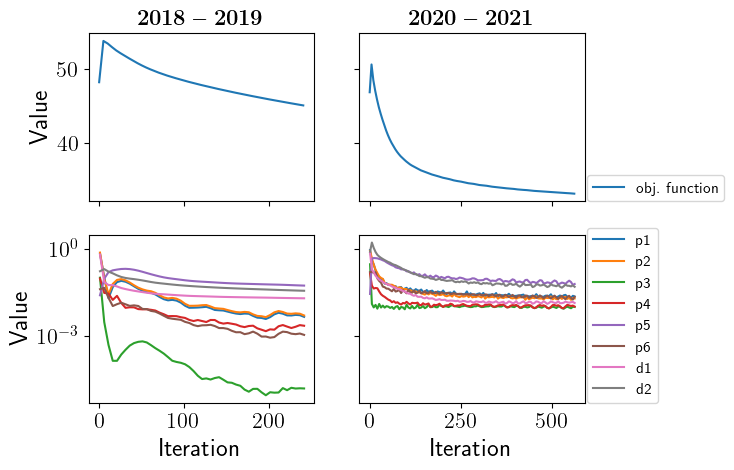

In [9]:
fig, ax = plt.subplots(2,2, sharex='col', sharey='row')
ax[0,0].plot(range(len(algo.objective_values))[::5], algo.objective_values[::5])
ax[0,1].plot(range(len(algo1.objective_values))[::5], algo1.objective_values[::5], label='obj. function')
pd.DataFrame(data=list(zip(jnp.abs(algo.Rp1s).tolist()[1::5],jnp.abs(algo.Rp2s).tolist()[1::5],jnp.abs(algo.Rp3s).tolist()[1::5],jnp.abs(algo.Rp4s).tolist()[1::5],jnp.abs(algo.Rp5s).tolist()[1::5],jnp.abs(algo.Rp6s).tolist()[1::5],jnp.abs(algo.Rd1s).tolist()[1::5],jnp.abs(algo.Rd2s).tolist()[1::5])),index=range(max_iter-1)[1::5], columns=["p1","p2","p3","p4","p5","p6","d1","d2"]).dropna().plot(ax=ax[1,0])
pd.DataFrame(data=list(zip(jnp.abs(algo1.Rp1s).tolist()[1::5],jnp.abs(algo1.Rp2s).tolist()[1::5],jnp.abs(algo1.Rp3s).tolist()[1::5],jnp.abs(algo1.Rp4s).tolist()[1::5],jnp.abs(algo1.Rp5s).tolist()[1::5],jnp.abs(algo1.Rp6s).tolist()[1::5],jnp.abs(algo1.Rd1s).tolist()[1::5],jnp.abs(algo1.Rd2s).tolist()[1::5])),index=range(max_iter-1)[1::5], columns=["p1","p2","p3","p4","p5","p6","d1","d2"]).dropna().plot(ax=ax[1,1])
ax[0,0].set_title(r'$\mathbf{2018-2019}$')
ax[0,1].set_title(r'$\mathbf{2020-2021}$')
ax[1,0].legend().set_visible(False)

ax[0,1].legend(loc=[1.01,0.])
ax[1,1].legend(loc=[1.01,0.])

ax[0,0].set_ylabel(r"Value")
ax[1,0].set_ylabel(r"Value")
ax[1,0].set_xlabel(r"Iteration")
ax[1,1].set_xlabel(r"Iteration")

ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')

plt.show()

In [11]:
#seaborn settings
sns.set_context('talk')
pal=sns.color_palette("ch:d=0,l=1", as_cmap=True)

#x-axis
K1 = jnp.array([16,8,4])
K1=jnp.append(jnp.insert(K1,0,0),2)

#alphabet for labels
alphabet = list(string.ascii_uppercase)

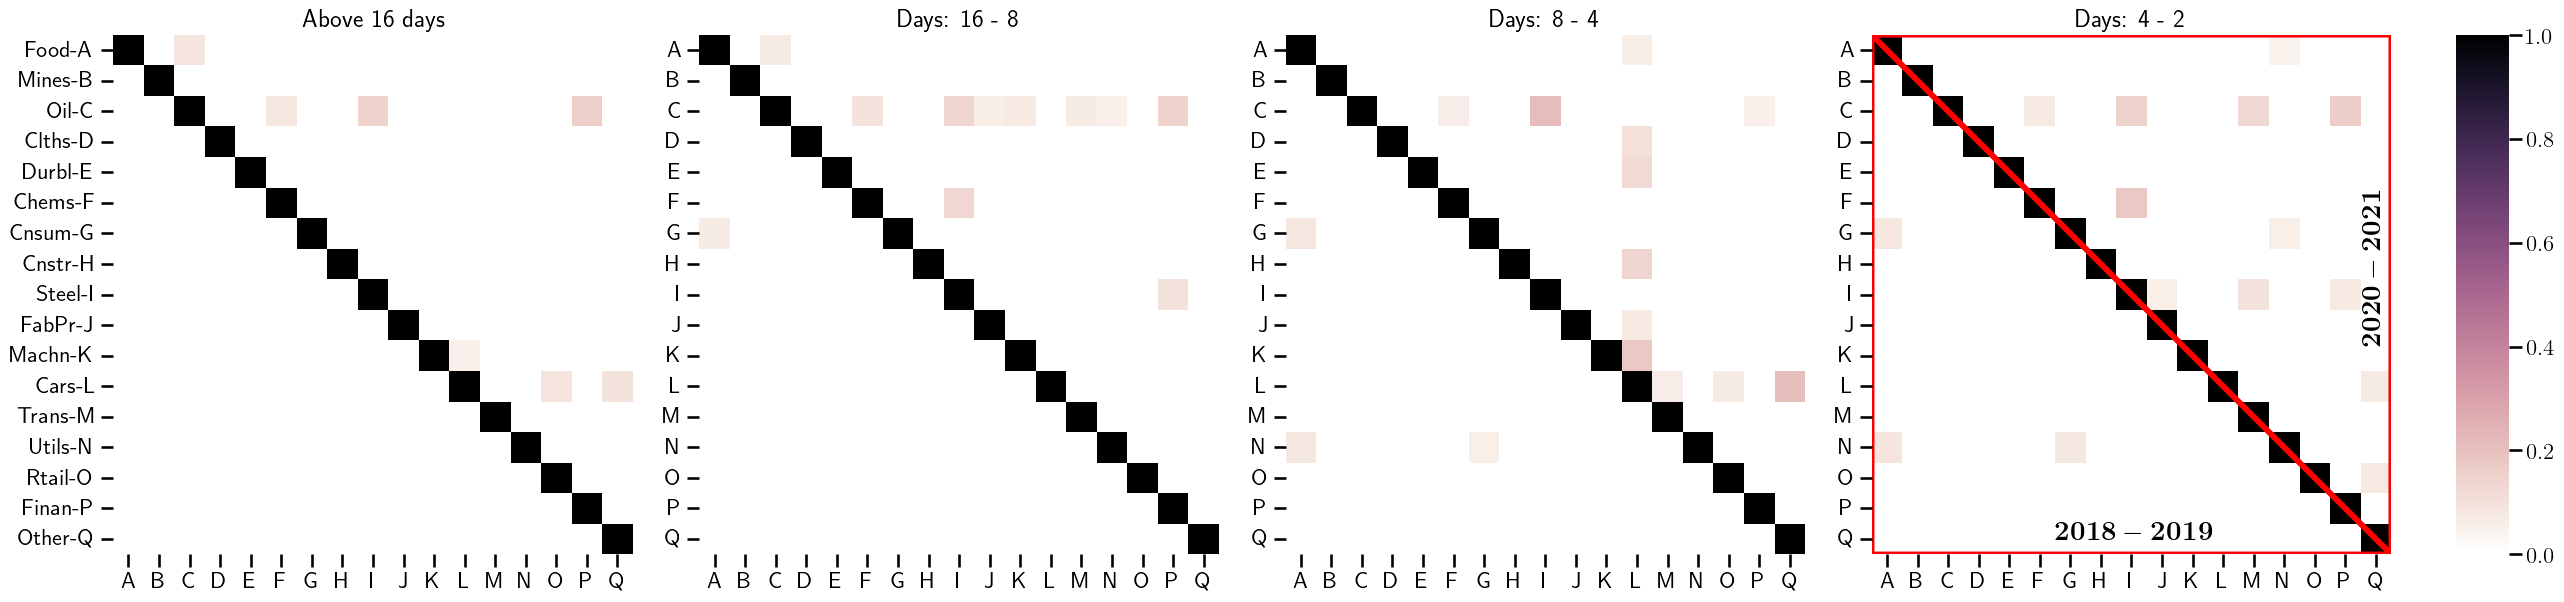

In [12]:
nrows=1
ncols=4
col_ = [rets_aft.columns[i].split(' ')[0]+'-'+alphabet[i] for i in range(len(rets_aft.columns))]
fig, ax = plt.subplots(nrows,ncols+1,figsize=(26,6), gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]}, sharex=False, sharey=False)

for k in range(Rl2_ours_aft.shape[-1]):
    if k%ncols==0:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_ours_bef[...,k].real>.05,Rl2_ours_bef[...,k].real,0)), index=col_, columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_ours_aft[...,k].real>.05,Rl2_ours_aft[...,k].real,0),k=1), index=col_, columns=alphabet[:len(rets_aft.columns)])
    else:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_ours_bef[...,k].real>.05,Rl2_ours_bef[...,k].real,0)), index=alphabet[:len(rets_bef.columns)], columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_ours_aft[...,k].real>.05,Rl2_ours_aft[...,k].real,0),k=1), index=alphabet[:len(rets_aft.columns)], columns=alphabet[:len(rets_aft.columns)])
    cbar_flag=True if k%ncols==ncols-1 else False
    sns.heatmap(bef_df+aft_df, cmap=pal, vmin=0, vmax=1, square=True,
                    cbar=cbar_flag, cbar_ax=ax[-1], ax=ax[k%ncols])
    
    if k%ncols!=0:
        ax[k%ncols].set_yticklabels(ax[k%ncols].get_yticklabels(),rotation=0)    
        ax[k%ncols].set_title(r"Days: %s - %s"%(K1[k],K1[k+1]))
    else:
        ax[k%ncols].set_title(r"Above %s days"%(K1[k+1]))
    

path = Path([[0,0],[0,17],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[3].add_patch(patch)

path = Path([[0,0],[17,0],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[3].add_patch(patch)

ax[3].text(s=r'$\mathbf{2018-2019}$', y=16.5, x=6, fontsize=20)
ax[3].text(s=r'$\mathbf{2020-2021}$', y=10, x=16, fontsize=20, rotation=90)

plt.tight_layout()
plt.show()

# Apply the Naive estimator

In [13]:
# Compute the inverse smoothed periodogram
P_bef=jax.vmap(hpinv,2,2)(sp_bef)
P_aft=jax.vmap(hpinv,2,2)(sp_aft)

# Naive estimator
R_naive_bef=array(partial_coherence(P_bef[...,::4])) 
Rl2_naive_bef=blocks_skeleton(R_naive_bef,K)
Rl2_naive_bef/=Rl2_naive_bef.max(axis=(0,1)).reshape((1,1,-1))

R_naive_aft=array(partial_coherence(P_aft[...,::4])) 
Rl2_naive_aft=blocks_skeleton(R_naive_aft,K)
Rl2_naive_aft/=Rl2_naive_aft.max(axis=(0,1)).reshape((1,1,-1))

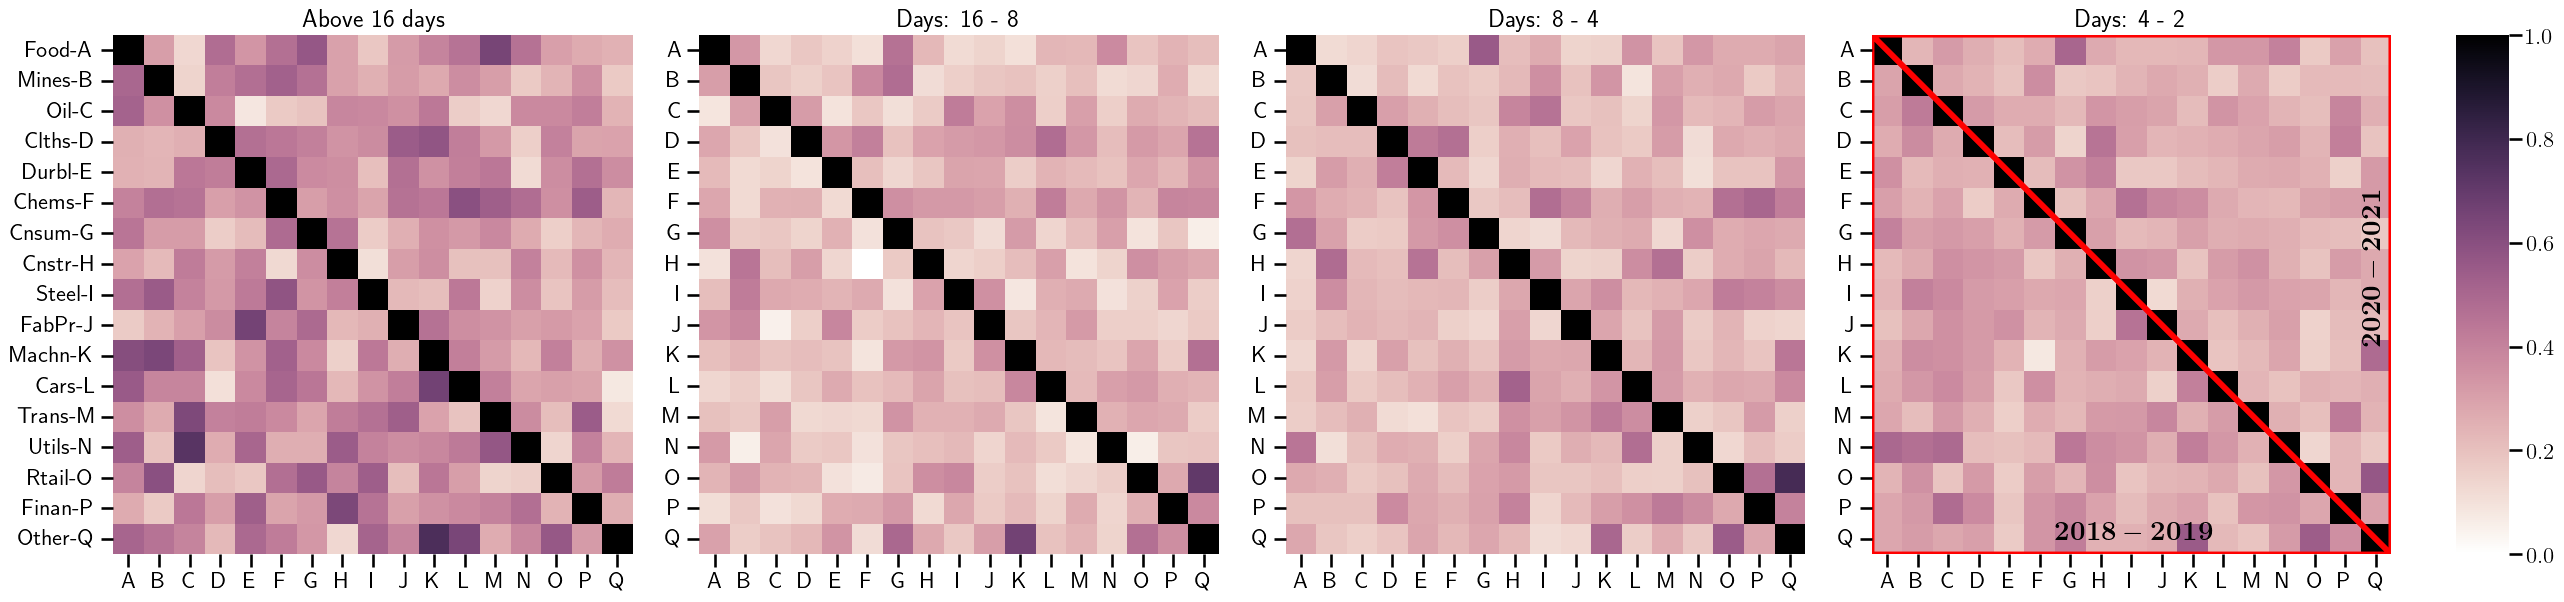

In [14]:
nrows=1
ncols=4
col_ = [rets_aft.columns[i].split(' ')[0]+'-'+alphabet[i] for i in range(len(rets_aft.columns))]
fig, ax = plt.subplots(nrows,ncols+1,figsize=(26,6), gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]}, sharex=False, sharey=False)

for k in range(Rl2_naive_aft.shape[-1]):
    if k%ncols==0:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_naive_bef[...,k].real>.05,Rl2_naive_bef[...,k].real,0)), index=col_, columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_naive_aft[...,k].real>.05,Rl2_naive_aft[...,k].real,0),k=1), index=col_, columns=alphabet[:len(rets_aft.columns)])
    else:
        bef_df=pd.DataFrame(jnp.tril(jnp.where(Rl2_naive_bef[...,k].real>.05,Rl2_naive_bef[...,k].real,0)), index=alphabet[:len(rets_bef.columns)], columns=alphabet[:len(rets_bef.columns)])
        aft_df=pd.DataFrame(jnp.triu(jnp.where(Rl2_naive_aft[...,k].real>.05,Rl2_naive_aft[...,k].real,0),k=1), index=alphabet[:len(rets_aft.columns)], columns=alphabet[:len(rets_aft.columns)])
    cbar_flag=True if k%ncols==ncols-1 else False
    sns.heatmap(bef_df+aft_df, cmap=pal, vmin=0, vmax=1, square=True,
                    cbar=cbar_flag, cbar_ax=ax[-1], ax=ax[k%ncols])
    if k%ncols!=0:
        ax[k%ncols].set_yticklabels(ax[k%ncols].get_yticklabels(),rotation=0)    
        ax[k%ncols].set_title(r"Days: %s - %s"%(K1[k],K1[k+1]))
    else:
        ax[k%ncols].set_title(r"Above %s days"%(K1[k+1]))

path = Path([[0,0],[0,17],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[3].add_patch(patch)

path = Path([[0,0],[17,0],[17,17],[0,0]])
patch = PathPatch(path, edgecolor='red', linestyle='-', linewidth=4, fill=False)
ax[3].add_patch(patch)

ax[3].text(s=r'$\mathbf{2018-2019}$', y=16.5, x=6, fontsize=20)
ax[3].text(s=r'$\mathbf{2020-2021}$', y=10, x=16, fontsize=20, rotation=90)

plt.tight_layout()
plt.show()